In [1]:
setwd("..")

In [2]:
source("Source/functions.R")
library("data.table")
library("ggplot2")
library("ggsignif")

In [3]:
snv_info <- fread("Data/snv_loci_v2.csv")
snvIDs <- snv_info[, SNVID]
mito_barcodes <- fread("Data/mito_barcodes.csv")
mitoIDs <- mito_barcodes[, ID] 

chrmbases_properties <- fread("Report/artifact/chrmbases_properties.csv.gz")
chrmbases <- chrmbases_properties[, ref]
nchrmbases <- length(chrmbases)

MitoInfo <- fread("Report/metadata/MitoInfo.csv")
MitoInfo[, ExptID := factor(ExptID)]
MitoInfo[, MitoID := factor(MitoID, levels = mitoIDs)]
MitoInfo[, CellID := factor(CellID)]

CellInfo <- fread("Report/metadata/CellInfo.csv")

MouseInfo <- fread("Report/metadata/MouseInfo.csv")

In [4]:
support_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
posmuts <- support_byposmut[, posmut]
noctrl_vars_start <- support_byposmut[, pos]
noctrl_vars_end <- noctrl_vars_start

noctrl_vars_vep <- data.table(
    chr = rep("MT", nrow(support_byposmut)),
    start = noctrl_vars_start, 
    end = noctrl_vars_end, 
    allele = support_byposmut[, paste0(ref, '/', ifelse(alt == "del", '-', alt))], 
    strand = rep("+", nrow(support_byposmut)), 
    id = support_byposmut[, posmut]
)
head(noctrl_vars_vep)

chr,start,end,allele,strand,id
<chr>,<int>,<int>,<chr>,<chr>,<chr>
MT,1224,1224,A/G,+,1224:A>G
MT,1224,1224,A/T,+,1224:A>T
MT,1225,1225,G/A,+,1225:G>A
MT,1226,1226,A/G,+,1226:A>G
MT,1228,1228,G/A,+,1228:G>A
MT,1228,1228,G/T,+,1228:G>T


In [ ]:
fwrite(noctrl_vars_vep, file = "Report/SNVs/impact/noctrl_vars.txt", col.names = FALSE, sep = "\t")

### Convert the VEP output into data table

In [6]:
vep <- fread("Report/SNVs/impact/noctrl_vep.txt", skip = 85, header = TRUE, sep = "\t")
setnames(vep, "#Uploaded_variation", "Uploaded_variation")
vep <- vep[Uploaded_variation %in% posmuts]
notes <- vep[, list(lapply(strsplit(Extra, ";"), function(x) { y <- strsplit(x, "="); n <- sapply(y, '[', 1); m <- sapply(y, '[', 2); structure(m, names = n) }))][, V1]
cnames <- Reduce(union, lapply(notes, names))
values <- t(sapply(notes, function(kv) kv[cnames]))
colnames(values) <- cnames
vep[, Extra := NULL]
vep <- data.table(vep, values)
vep <- support_byposmut[vep, on = c("posmut" = "Uploaded_variation")]
vep[Consequence == "start_lost", Location:IMPACT]

Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MT:9459,G,ENSMUSG00000064360,ENSMUST00000082411,Transcript,start_lost,1,1,1,M/V,Att/Gtt,-,HIGH
MT:9461,C,ENSMUSG00000064360,ENSMUST00000082411,Transcript,start_lost,3,3,1,M/I,atT/atC,-,HIGH


Note, VEP currently missed the alternative initial codon for mouse mito, see https://github.com/Ensembl/ensembl-vep/issues/1292.  
As a result, 9461 should be synonymous SNV in fact. VEP mistakenly annotated it as nonsyn and high impact.  
Let's manually correct it. 

In [7]:
vep[Consequence == "start_lost" & posmut == "9461:T>C", c("Consequence", "IMPACT") := list("synonymous_variant", "LOW")]
vep[pos == 9461 & Feature_type == "Transcript" & Consequence == "synonymous_variant", Location:IMPACT]

Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MT:9461,A,ENSMUSG00000064360,ENSMUST00000082411,Transcript,synonymous_variant,3,3,1,M,atT/atA,-,LOW
MT:9461,C,ENSMUSG00000064360,ENSMUST00000082411,Transcript,synonymous_variant,3,3,1,M/I,atT/atC,-,LOW


In [ ]:
fwrite(vep, file = "Report/SNVs/impact/noctrl_vep.csv")

Annotate and deduplicate SNVs

In [9]:
vep <- fread(file = "Report/SNVs/impact/noctrl_vep.csv")
vep_synonymous <- vep[Feature_type == "Transcript" & Consequence == "synonymous_variant"]
vep_synonymous[, list(uniqueN(posmut), .N)]

V1,N
<int>,<int>
189,189


In [10]:
vep_nonsynonymous <- vep[Feature_type == "Transcript" & Consequence %in% c("frameshift_variant", "incomplete_terminal_codon_variant,coding_sequence_variant", "missense_variant", "start_lost", "stop_gained")]
vep_nonsynonymous[, list(uniqueN(posmut), .N)]

V1,N
<int>,<int>
440,440


In [11]:
vep_tRNA <- vep[Feature_type == "Transcript" & Consequence == "non_coding_transcript_exon_variant" & BIOTYPE == "Mt_tRNA"]
vep_tRNA[, list(uniqueN(posmut), .N)]

V1,N
<int>,<int>
161,162


In [12]:
options(repr.matrix.max.cols = 41)
vep_tRNA[posmut == "3772:C>T"]

posmut,SNVID,pos,mut,ref,alt,nmice,ncells,nmitos,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,VARIANT_CLASS,SYMBOL,SYMBOL_SOURCE,BIOTYPE,CANONICAL,GENE_PHENO,EXON,HGVSc,APPRIS,ENSP,SWISSPROT,TREMBL,UNIPARC,SIFT,DOMAINS,HGVSp,HGVS_OFFSET
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
3772:C>T,SNV5,3772,C>T,C,T,1,1,1,MT:3772,T,ENSMUSG00000064342,ENSMUST00000082393,Transcript,non_coding_transcript_exon_variant,67,-,-,-,-,-,MODIFIER,NA,1,SNV,mt-Ti,MGI,Mt_tRNA,YES,NA,1/1,ENSMUST00000082393.1:n.67C>T,,,,,,,,,NA
3772:C>T,SNV5,3772,C>T,C,T,1,1,1,MT:3772,T,ENSMUSG00000064343,ENSMUST00000082394,Transcript,non_coding_transcript_exon_variant,71,-,-,-,-,-,MODIFIER,NA,-1,SNV,mt-Tq,MGI,Mt_tRNA,YES,NA,1/1,ENSMUST00000082394.1:n.71G>A,,,,,,,,,NA


Because they have almost equal impact, we decide to keep Ti only.

In [13]:
vep_tRNA <- vep_tRNA[!duplicated(posmut)]

In [14]:
vep_rRNA <- vep[Feature_type == "Transcript" & Consequence == "non_coding_transcript_exon_variant" & BIOTYPE == "Mt_rRNA"]
vep_rRNA[, list(uniqueN(posmut), .N)]

V1,N
<int>,<int>
147,147


In [15]:
vep_dloop <- vep[Feature_type == "RegulatoryFeature" & Consequence == "regulatory_region_variant" & pos > 15422][!posmut %in% Reduce(union, list(vep_nonsynonymous[, posmut], vep_synonymous[, posmut], vep_tRNA[, posmut], vep_rRNA[, posmut]))]
vep_dloop[, list(uniqueN(posmut), .N)]

V1,N
<int>,<int>
93,93


In [16]:
vep_intergenic <- vep[Feature_type == "RegulatoryFeature" & Consequence == "regulatory_region_variant" & BIOTYPE == "promoter_flanking_region"][!posmut %in% Reduce(union, list(vep_nonsynonymous[, posmut], vep_synonymous[, posmut], vep_tRNA[, posmut], vep_rRNA[, posmut], vep_dloop[, posmut]))]
vep_intergenic

posmut,SNVID,pos,mut,ref,alt,nmice,ncells,nmitos,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,VARIANT_CLASS,SYMBOL,SYMBOL_SOURCE,BIOTYPE,CANONICAL,GENE_PHENO,EXON,HGVSc,APPRIS,ENSP,SWISSPROT,TREMBL,UNIPARC,SIFT,DOMAINS,HGVSp,HGVS_OFFSET
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
3843:A>G,SNV5,3843,A>G,A,G,2,2,2,MT:3843,G,-,ENSMUSR00000758872,RegulatoryFeature,regulatory_region_variant,-,-,-,-,-,-,MODIFIER,NA,NA,SNV,,,promoter_flanking_region,,NA,,,,,,,,,,,NA
3844:T>C,SNV5,3844,T>C,T,C,1,1,1,MT:3844,C,-,ENSMUSR00000758872,RegulatoryFeature,regulatory_region_variant,-,-,-,-,-,-,MODIFIER,NA,NA,SNV,,,promoter_flanking_region,,NA,,,,,,,,,,,NA


In [17]:
vep_nonsynonymous[, class := "nonsynonymous"]
vep_synonymous[, class := "synonymous"]
vep_tRNA[, class := "tRNA"]
vep_rRNA[, class := "rRNA"]
vep_dloop[, class := "D-loop"]
vep_intergenic[, class := "intergenic"]
vep_nonsynonymous[, uniqueN(posmut)] + vep_synonymous[, uniqueN(posmut)] + vep_tRNA[, uniqueN(posmut)] + vep_rRNA[, uniqueN(posmut)] + vep_dloop[, uniqueN(posmut)] + vep_intergenic[, uniqueN(posmut)]

[1] 1032

In [18]:
vep_unique <- rbindlist(list(vep_nonsynonymous, vep_synonymous, vep_tRNA, vep_rRNA, vep_dloop, vep_intergenic))
sum(vep_unique[, table(class)])

[1] 1032

In [ ]:
fwrite(vep_unique, file = "Report/SNVs/impact/noctrl_vep_unique.csv")

SNV occurrence by predicted functional consequence

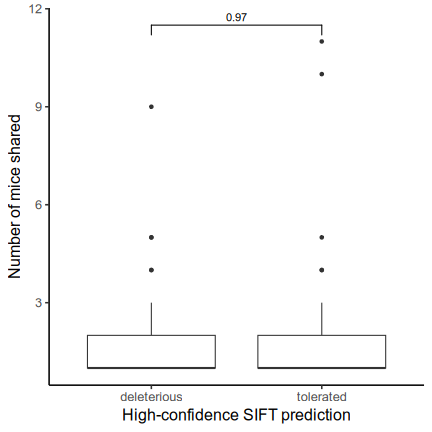

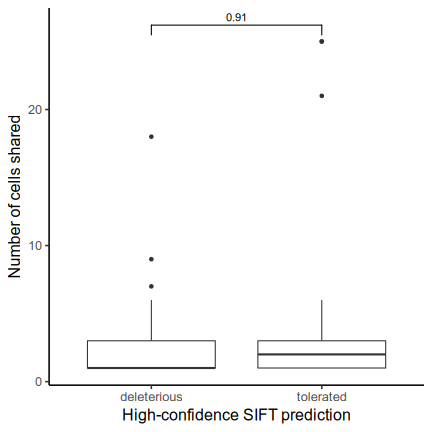

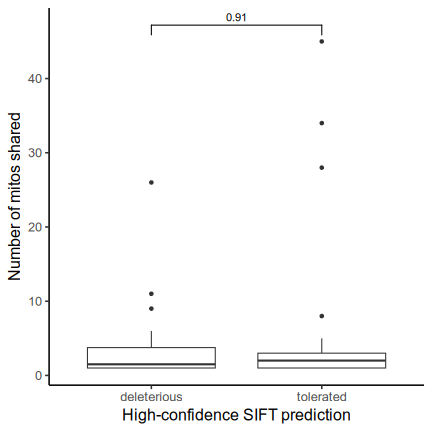

In [20]:
noctrl_sift <- fread("Report/SNVs/impact/noctrl_impact_added_SIFT.tsv")

options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 72)
ggplot(noctrl_sift[SIFT_confidence == "high"], aes(x = SIFT_prediction, y = `# mice`)) + geom_boxplot() + theme_classic(base_size = 16) + geom_signif(comparisons = list(c("tolerated", "deleterious"))) + xlab("High-confidence SIFT prediction") + ylab("Number of mice shared")
ggplot(noctrl_sift[SIFT_confidence == "high"], aes(x = SIFT_prediction, y = `# cells`)) + geom_boxplot() + theme_classic(base_size = 16) + geom_signif(comparisons = list(c("tolerated", "deleterious"))) + xlab("High-confidence SIFT prediction") + ylab("Number of cells shared")
ggplot(noctrl_sift[SIFT_confidence == "high"], aes(x = SIFT_prediction, y = `# mitos`)) + geom_boxplot() + theme_classic(base_size = 16) + geom_signif(comparisons = list(c("tolerated", "deleterious"))) + xlab("High-confidence SIFT prediction") + ylab("Number of mitos shared")

Poisson regression

In [21]:
summary(glm(`# mitos` ~ SIFT_prediction, data = noctrl_sift[SIFT_confidence == "high"], family = poisson(link = "log")))


Call:
glm(formula = `# mitos` ~ SIFT_prediction, family = poisson(link = "log"), 
    data = noctrl_sift[SIFT_confidence == "high"])

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.23353    0.09853  12.519   <2e-16 ***
SIFT_predictiontolerated  0.15276    0.12087   1.264    0.206    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 497.74  on 80  degrees of freedom
Residual deviance: 496.11  on 79  degrees of freedom
AIC: 715.3

Number of Fisher Scoring iterations: 6


In [22]:
summary(glm(`# cells` ~ SIFT_prediction, data = noctrl_sift[SIFT_confidence == "high"], family = poisson(link = "log")))


Call:
glm(formula = `# cells` ~ SIFT_prediction, family = poisson(link = "log"), 
    data = noctrl_sift[SIFT_confidence == "high"])

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.06471    0.10721   9.931   <2e-16 ***
SIFT_predictiontolerated  0.07864    0.13320   0.590    0.555    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 301.75  on 80  degrees of freedom
Residual deviance: 301.40  on 79  degrees of freedom
AIC: 514.81

Number of Fisher Scoring iterations: 5


Among all SNVs, number of SNV sites per gene locus per number-of-mitos sharing

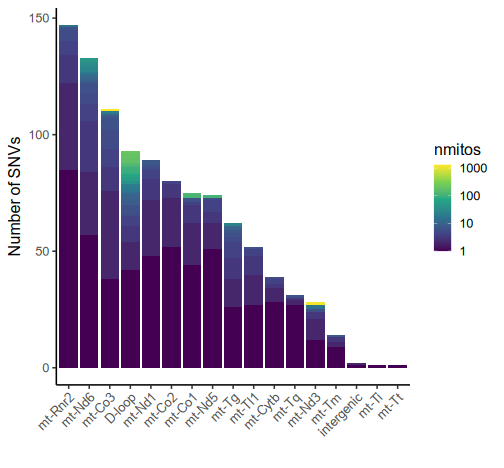

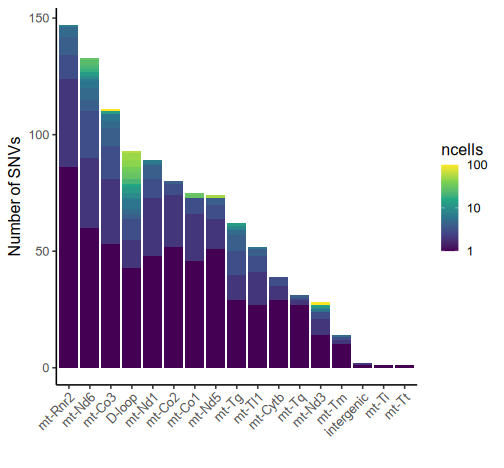

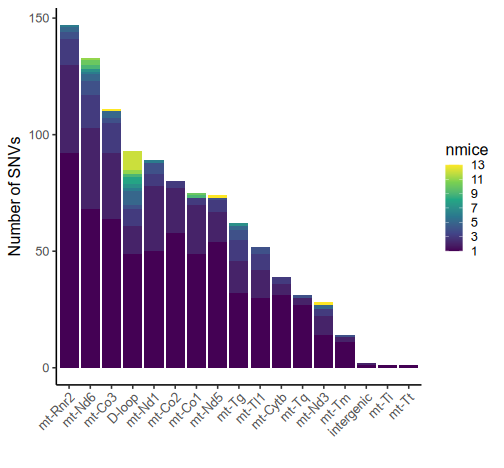

In [23]:
vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
vep[, gene := ifelse(SYMBOL == "", class, SYMBOL)]
options(repr.plot.width = 7, repr.plot.height = 6.5, repr.plot.res = 72)
ggplot(vep[, .N, by = c("gene", "nmitos")][order(nmitos)], aes(x = gene, y = N, fill = nmitos)) + geom_bar(stat = "identity") + scale_x_discrete(limits = vep[, .N, by = "gene"][order(-N), gene]) + theme_classic(base_size = 16) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("Number of SNVs") + scale_fill_viridis_c(breaks = c(1, 10, 100, 1000), labels = c(1, 10, 100, 1000), trans = scales::log_trans()) + scale_y_continuous(breaks = seq(0, 150, by = 50))
options(repr.plot.width = 7, repr.plot.height = 6.5, repr.plot.res = 72)
ggplot(vep[, .N, by = c("gene", "ncells")][order(ncells)], aes(x = gene, y = N, fill = ncells)) + geom_bar(stat = "identity") + scale_x_discrete(limits = vep[, .N, by = "gene"][order(-N), gene]) + theme_classic(base_size = 16) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("Number of SNVs") + scale_fill_viridis_c(breaks = c(1, 10, 100, 1000), labels = c(1, 10, 100, 1000), trans = scales::log_trans())
options(repr.plot.width = 7, repr.plot.height = 6.5, repr.plot.res = 72)
ggplot(vep[, .N, by = c("gene", "nmice")][order(nmice)], aes(x = gene, y = N, fill = nmice)) + geom_bar(stat = "identity") + scale_x_discrete(limits = vep[, .N, by = "gene"][order(-N), gene]) + theme_classic(base_size = 16) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("Number of SNVs") + scale_fill_viridis_c(breaks = seq(1, 13, by = 2), labels = seq(1, 13, by = 2))

Among all SNVs, how is the per-base SNV occurrence per region?

In [24]:
vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
vep[, gene := ifelse(SYMBOL == "", class, SYMBOL)]
chrmgenes <- fread("Report/artifact/chrmgenes.csv")
## get D-loop and intergenic info
chrmgenes <- rbind(chrmgenes,
    chrmbases_properties[is_in_range == "Y" & is_in_primer == "N" & SNVID == "SNV8", list(symbol = "D-loop", start = min(pos), end = max(pos), strand = "*", nbases_covered = .N)], 
    chrmbases_properties[pos %in% 3843:3844, list(symbol = "intergenic", start = min(pos), end = max(pos), strand = "*", nbases_covered = .N)]
)
npos_bygene <- vep[, list(npos = uniqueN(pos)), by = c("gene")]
npos_bygene <- chrmgenes[, c("symbol", "nbases_covered")][npos_bygene, on = c(symbol = "gene")]
npos_bygene[, npos_perbase := npos / nbases_covered]
setnames(npos_bygene, "symbol", "gene")
npos_bygene

gene,nbases_covered,npos,npos_perbase
<chr>,<int>,<int>,<dbl>
mt-Nd1,118,74,0.6271186
mt-Co1,119,64,0.5378151
mt-Co2,120,64,0.5333333
mt-Co3,138,91,0.6594203
mt-Nd3,31,22,0.7096774
mt-Nd5,120,66,0.5500000
mt-Nd6,118,98,0.8305085
mt-Cytb,114,36,0.3157895
mt-Tl1,55,42,0.7636364


In [ ]:
fwrite(npos_bygene[order(-npos_perbase)], file = "Report/SNVs/impact/noctrl_vep_npos_bygene_perbase.csv")

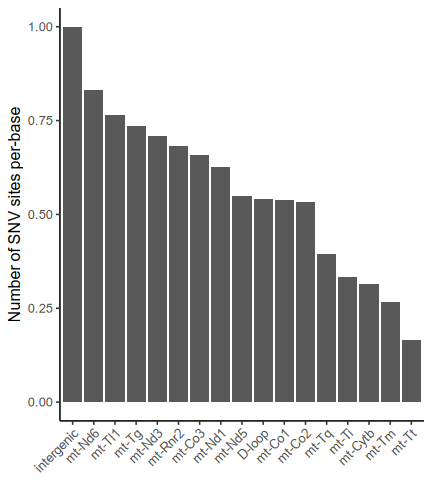

In [26]:
options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 72)
ggplot(npos_bygene, aes(x = gene, y = npos_perbase)) + geom_bar(stat = "identity") + scale_x_discrete(limits = npos_bygene[order(-npos_perbase), gene]) + theme_classic(base_size = 16) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("Number of SNV sites per-base")

Transition probability matrix for all SNVs

In [27]:
support_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
transmat <- dcast.data.table(support_byposmut[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
transmat

ref,A,C,G,T,del
<chr>,<int>,<int>,<int>,<int>,<int>
A,NA,39,275,28,11
C,90,NA,18,173,5
G,89,11,NA,41,NA
T,24,204,21,NA,3


Because of the deletions, the sum of ti and tv will be less than 1032.

In [28]:
vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
vep_nonsynonymous <- vep[class == "nonsynonymous"]
vep_synonymous <- vep[class  == "synonymous"]
vep_tRNA <- vep[class == "tRNA"]
vep_rRNA <- vep[class == "rRNA"]
vep_dloop <- vep[class == "D-loop"]
vep_intergenic <- vep[class == "intergenic"]

vep_synonymous_posmut <- vep_synonymous[, unique(posmut)]
vep_nonsynonymous_posmut <- vep_nonsynonymous[, unique(posmut)]
vep_tRNA_posmut <- vep_tRNA[, unique(posmut)]
vep_rRNA_posmut <- vep_rRNA[, unique(posmut)]
vep_dloop_posmut <- vep_dloop[, unique(posmut)]
vep_intergenic_posmut <- vep_intergenic[, unique(posmut)]

transmat_nonsynonymous <- dcast.data.table(support_byposmut[posmut %in% vep_nonsynonymous_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
transmat_synonymous <- dcast.data.table(support_byposmut[posmut %in% vep_synonymous_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
transmat_tRNA <- dcast.data.table(support_byposmut[posmut %in% vep_tRNA_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
transmat_rRNA <- dcast.data.table(support_byposmut[posmut %in% vep_rRNA_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
transmat_dloop <- dcast.data.table(support_byposmut[posmut %in% vep_dloop_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
transmat_intergenic <- dcast.data.table(support_byposmut[posmut %in% vep_intergenic_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")

In [ ]:
Tools$write_xlsx(list(
    all = transmat,
    nonsynonymous = transmat_nonsynonymous, 
    synonymous = transmat_synonymous, 
    tRNA = transmat_tRNA, 
    rRNA = transmat_rRNA, 
    dloop= transmat_dloop, 
    intergenic = transmat_intergenic
), file = "Report/SNVs/impact/noctrl_transmat.xlsx", row.names = FALSE)

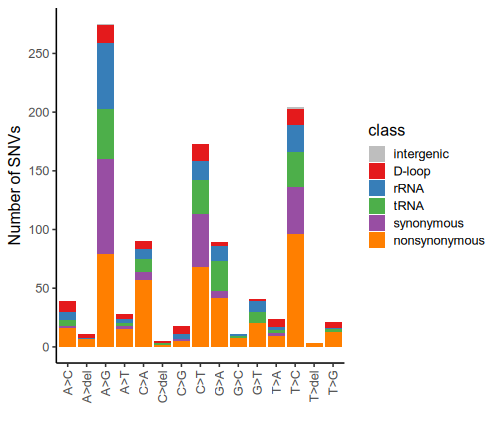

In [30]:
support_byposmut[, mut := factor(mut, levels = setdiff(paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "del")), c("A>A", "C>C", "G>G", "T>T")))]

options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
colmap <- structure(c(RColorBrewer::brewer.pal(5, "Set1"), "gray"), names = c("D-loop", "rRNA", "tRNA", "synonymous", "nonsynonymous", "intergenic"))[c(6, 1:5)]
nsnvs_byclass <- melt.data.table(dcast.data.table(vep, mut ~ class, fun.aggregate = function(x) uniqueN(x), value.var = "pos"), id.vars = "mut", variable.name = "class", value.name = "nsnvs")
nsnvs_byclass[, class := factor(class, levels = c("intergenic", "D-loop", "rRNA", "tRNA", "synonymous", "nonsynonymous"))]
ggplot(nsnvs_byclass, aes(x = mut, y = nsnvs, fill = class)) + geom_bar(stat = "identity") + theme_classic(16) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) + xlab("") + ylab("Number of SNVs") + scale_fill_manual(values = colmap) + scale_y_continuous(breaks = seq(0, 300, by = 50))

In [31]:
noctrl_titv <- list(
    all = Genetics$titv(Tools$dt2df(transmat)), 
    nonsynonymous = Genetics$titv(Tools$dt2df(transmat_nonsynonymous)),
    synonymous = Genetics$titv(Tools$dt2df(transmat_synonymous)),
    tRNA = Genetics$titv(Tools$dt2df(transmat_tRNA)),
    rRNA = Genetics$titv(Tools$dt2df(transmat_rRNA)),
    dloop = Genetics$titv(Tools$dt2df(transmat_dloop)), 
    intergenic = Genetics$titv(Tools$dt2df(transmat_intergenic))
)
noctrl_titv <- do.call(rbind, noctrl_titv)
noctrl_titv <- data.table(class = rownames(noctrl_titv), noctrl_titv)
head(noctrl_titv)

class,ti,tv,r
<chr>,<dbl>,<dbl>,<dbl>
all,741,272,2.724265
nonsynonymous,285,143,1.993007
synonymous,172,17,10.117647
tRNA,127,33,3.848485
rRNA,108,38,2.842105
dloop,47,41,1.146341


In [ ]:
fwrite(noctrl_titv, file = "Report/SNVs/impact/noctrl_titv.csv")

Among inherited SNVs, how is the per-base mutation occurrence per region?

In [33]:
vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
vep[, gene := ifelse(SYMBOL == "", class, SYMBOL)]
inherited_noctrl_vep <- vep[nmice >= 3]
chrmgenes <- fread("Report/artifact/chrmgenes.csv")
## get D-loop and intergenic info
chrmgenes <- rbind(chrmgenes,
    chrmbases_properties[is_in_range == "Y" & is_in_primer == "N" & SNVID == "SNV8", list(symbol = "D-loop", start = min(pos), end = max(pos), strand = "*", nbases_covered = .N)], 
    chrmbases_properties[pos %in% 3843:3844, list(symbol = "intergenic", start = min(pos), end = max(pos), strand = "*", nbases_covered = .N)]
)
inherited_noctrl_npos_bygene <- inherited_noctrl_vep[, list(npos = uniqueN(pos)), by = c("gene")]
inherited_noctrl_npos_bygene <- chrmgenes[, c("symbol", "nbases_covered")][inherited_noctrl_npos_bygene, on = c(symbol = "gene")]
inherited_noctrl_npos_bygene[, npos_perbase := npos / nbases_covered]
setnames(inherited_noctrl_npos_bygene, "symbol", "gene")
inherited_noctrl_npos_bygene

gene,nbases_covered,npos,npos_perbase
<chr>,<int>,<int>,<dbl>
mt-Nd1,118,11,0.09322034
mt-Co1,119,5,0.04201681
mt-Co2,120,3,0.02500000
mt-Co3,138,19,0.13768116
mt-Nd3,31,6,0.19354839
mt-Nd5,120,7,0.05833333
mt-Nd6,118,26,0.22033898
mt-Cytb,114,3,0.02631579
mt-Tl1,55,10,0.18181818


In [ ]:
fwrite(inherited_noctrl_npos_bygene[order(-npos_perbase)], file = "Report/SNVs/impact/inherited_noctrl_vep_npos_bygene_perbase.csv")

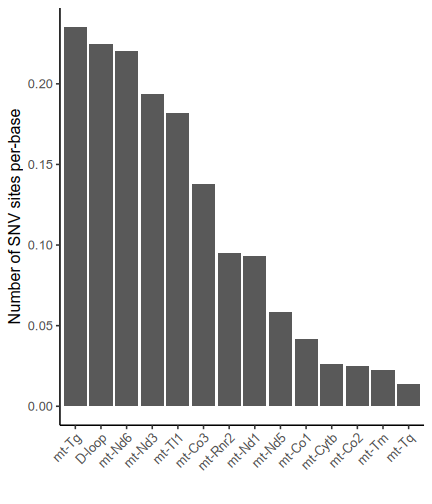

In [35]:
options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 72)
ggplot(inherited_noctrl_npos_bygene, aes(x = gene, y = npos_perbase)) + geom_bar(stat = "identity") + scale_x_discrete(limits = inherited_noctrl_npos_bygene[order(-npos_perbase), gene]) + theme_classic(base_size = 16) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("Number of SNV sites per-base")

Among somatic SNVs, how is the per-base mutation occurrence per region?

In [36]:
vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
vep[, gene := ifelse(SYMBOL == "", class, SYMBOL)]
somatic_noctrl_vep <- vep[nmice == 1]
chrmgenes <- fread("Report/artifact/chrmgenes.csv")
## get D-loop and intergenic info
chrmgenes <- rbind(chrmgenes,
    chrmbases_properties[is_in_range == "Y" & is_in_primer == "N" & SNVID == "SNV8", list(symbol = "D-loop", start = min(pos), end = max(pos), strand = "*", nbases_covered = .N)], 
    chrmbases_properties[pos %in% 3843:3844, list(symbol = "intergenic", start = min(pos), end = max(pos), strand = "*", nbases_covered = .N)]
)
somatic_noctrl_npos_bygene <- somatic_noctrl_vep[, list(npos = uniqueN(pos)), by = c("gene")]
somatic_noctrl_npos_bygene <- chrmgenes[, c("symbol", "nbases_covered")][somatic_noctrl_npos_bygene, on = c(symbol = "gene")]
somatic_noctrl_npos_bygene[, npos_perbase := npos / nbases_covered]
setnames(somatic_noctrl_npos_bygene, "symbol", "gene")
somatic_noctrl_npos_bygene

gene,nbases_covered,npos,npos_perbase
<chr>,<int>,<int>,<dbl>
mt-Nd1,118,45,0.3813559
mt-Co1,119,45,0.3781513
mt-Co2,120,48,0.4000000
mt-Co3,138,55,0.3985507
mt-Nd3,31,12,0.3870968
mt-Nd5,120,51,0.4250000
mt-Nd6,118,57,0.4830508
mt-Cytb,114,28,0.2456140
mt-Tl1,55,28,0.5090909


In [ ]:
fwrite(somatic_noctrl_npos_bygene[order(-npos_perbase)], file = "Report/SNVs/impact/somatic_noctrl_vep_npos_bygene_perbase.csv")

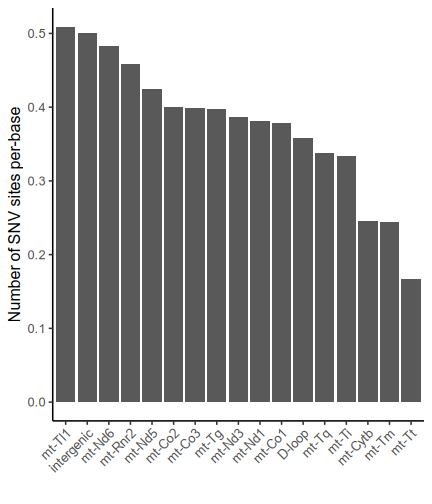

In [38]:
options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 72)
ggplot(somatic_noctrl_npos_bygene, aes(x = gene, y = npos_perbase)) + geom_bar(stat = "identity") + scale_x_discrete(limits = somatic_noctrl_npos_bygene[order(-npos_perbase), gene]) + theme_classic(base_size = 16) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("Number of SNV sites per-base")

Transition probability matrix for inherited SNVs

In [39]:
support_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
inherited_noctrl_transmat <- dcast.data.table(support_byposmut[nmice >= 3, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")

vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
inherited_noctrl_vep <- vep[nmice >= 3]
inherited_noctrl_vep_nonsynonymous <- inherited_noctrl_vep[class == "nonsynonymous"]
inherited_noctrl_vep_synonymous <- inherited_noctrl_vep[class  == "synonymous"]
inherited_noctrl_vep_tRNA <- inherited_noctrl_vep[class == "tRNA"]
inherited_noctrl_vep_rRNA <- inherited_noctrl_vep[class == "rRNA"]
inherited_noctrl_vep_dloop <- inherited_noctrl_vep[class == "D-loop"]

inherited_noctrl_vep_synonymous_posmut <- inherited_noctrl_vep_synonymous[, unique(posmut)]
inherited_noctrl_vep_nonsynonymous_posmut <- inherited_noctrl_vep_nonsynonymous[, unique(posmut)]
inherited_noctrl_vep_tRNA_posmut <- inherited_noctrl_vep_tRNA[, unique(posmut)]
inherited_noctrl_vep_rRNA_posmut <- inherited_noctrl_vep_rRNA[, unique(posmut)]
inherited_noctrl_vep_dloop_posmut <- inherited_noctrl_vep_dloop[, unique(posmut)]

inherited_noctrl_transmat_nonsynonymous <- dcast.data.table(support_byposmut[posmut %in% inherited_noctrl_vep_nonsynonymous_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
inherited_noctrl_transmat_synonymous <- dcast.data.table(support_byposmut[posmut %in% inherited_noctrl_vep_synonymous_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
inherited_noctrl_transmat_tRNA <- dcast.data.table(support_byposmut[posmut %in% inherited_noctrl_vep_tRNA_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
inherited_noctrl_transmat_rRNA <- dcast.data.table(support_byposmut[posmut %in% inherited_noctrl_vep_rRNA_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
inherited_noctrl_transmat_dloop <- dcast.data.table(support_byposmut[posmut %in% inherited_noctrl_vep_dloop_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")

In [ ]:
Tools$write_xlsx(list(
    all = inherited_noctrl_transmat,
    nonsynonymous = inherited_noctrl_transmat_nonsynonymous, 
    synonymous = inherited_noctrl_transmat_synonymous, 
    tRNA = inherited_noctrl_transmat_tRNA, 
    rRNA = inherited_noctrl_transmat_rRNA, 
    dloop= inherited_noctrl_transmat_dloop
), file = "Report/SNVs/impact/inherited_noctrl_transmat.xlsx", row.names = FALSE)

Ti/Tv for inherited SNVs

In [41]:
inherited_noctrl_titv <- list(
    all = Genetics$titv(Tools$dt2df(inherited_noctrl_transmat)), 
    nonsynonymous = Genetics$titv(Tools$dt2df(inherited_noctrl_transmat_nonsynonymous)),
    synonymous = Genetics$titv(Tools$dt2df(inherited_noctrl_transmat_synonymous)),
    tRNA = Genetics$titv(Tools$dt2df(inherited_noctrl_transmat_tRNA)),
    rRNA = Genetics$titv(Tools$dt2df(inherited_noctrl_transmat_rRNA)),
    dloop = Genetics$titv(Tools$dt2df(inherited_noctrl_transmat_dloop))
)
inherited_noctrl_titv <- do.call(rbind, inherited_noctrl_titv)
inherited_noctrl_titv <- data.table(class = rownames(inherited_noctrl_titv), inherited_noctrl_titv)
inherited_noctrl_titv

class,ti,tv,r
<chr>,<dbl>,<dbl>,<dbl>
all,117,39,3.0000000
nonsynonymous,44,14,3.1428571
synonymous,22,2,11.0000000
tRNA,26,2,13.0000000
rRNA,17,0,Inf
dloop,8,21,0.3809524


In [ ]:
fwrite(inherited_noctrl_titv, file = "Report/SNVs/impact/inherited_noctrl_titv.csv")

In [43]:
## Ti/Tv per gene
vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
inherited_noctrl_vep <- vep[nmice >= 3]
inherited_noctrl_vep[, gene := SYMBOL]
inherited_noctrl_vep[, gene := ifelse(gene == "", class, gene)]
inherited_noctrl_vep[, table(gene)]

gene
 D-loop  mt-Co1  mt-Co2  mt-Co3 mt-Cytb  mt-Nd1  mt-Nd3  mt-Nd5  mt-Nd6 mt-Rnr2 
     32       5       3      19       3      11       6       7      30      17 
  mt-Tg  mt-Tl1   mt-Tm   mt-Tq 
     16      10       1       1 

In [44]:
inherited_noctrl_transmat_bygene <- sapply(inherited_noctrl_vep[, sort(unique(gene))], function(g) dcast.data.table(inherited_noctrl_vep[gene == g, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
inherited_noctrl_titv_bygene <- t(sapply(inherited_noctrl_transmat_bygene, function(dt) Genetics$titv(Tools$dt2df(dt))))
inherited_noctrl_titv_bygene <- data.table(gene = rownames(inherited_noctrl_titv_bygene), inherited_noctrl_titv_bygene)
inherited_noctrl_titv_bygene

gene,ti,tv,r
<chr>,<dbl>,<dbl>,<dbl>
D-loop,8,21,0.3809524
mt-Co1,2,3,0.6666667
mt-Co2,3,0,Inf
mt-Co3,16,3,5.3333333
mt-Cytb,3,0,Inf
mt-Nd1,10,1,10.0000000
mt-Nd3,6,0,Inf
mt-Nd5,6,1,6.0000000
mt-Nd6,20,8,2.5000000


In [ ]:
fwrite(inherited_noctrl_titv_bygene, file = "Report/SNVs/impact/inherited_noctrl_titv_bygene.csv")

Transition probability matrix for somatic SNVs

In [46]:
support_byposmut <- fread("Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
somatic_noctrl_transmat <- dcast.data.table(support_byposmut[nmice == 1, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")

vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
somatic_noctrl_vep <- vep[nmice == 1]
somatic_noctrl_vep_nonsynonymous <- somatic_noctrl_vep[class == "nonsynonymous"]
somatic_noctrl_vep_synonymous <- somatic_noctrl_vep[class  == "synonymous"]
somatic_noctrl_vep_tRNA <- somatic_noctrl_vep[class == "tRNA"]
somatic_noctrl_vep_rRNA <- somatic_noctrl_vep[class == "rRNA"]
somatic_noctrl_vep_dloop <- somatic_noctrl_vep[class == "D-loop"]
somatic_noctrl_vep_intergenic <- somatic_noctrl_vep[class == "intergenic"]

somatic_noctrl_vep_synonymous_posmut <- somatic_noctrl_vep_synonymous[, unique(posmut)]
somatic_noctrl_vep_nonsynonymous_posmut <- somatic_noctrl_vep_nonsynonymous[, unique(posmut)]
somatic_noctrl_vep_tRNA_posmut <- somatic_noctrl_vep_tRNA[, unique(posmut)]
somatic_noctrl_vep_rRNA_posmut <- somatic_noctrl_vep_rRNA[, unique(posmut)]
somatic_noctrl_vep_dloop_posmut <- somatic_noctrl_vep_dloop[, unique(posmut)]
somatic_noctrl_vep_intergenic_posmut <- somatic_noctrl_vep_intergenic[, unique(posmut)]

somatic_noctrl_transmat_nonsynonymous <- dcast.data.table(support_byposmut[posmut %in% somatic_noctrl_vep_nonsynonymous_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
somatic_noctrl_transmat_synonymous <- dcast.data.table(support_byposmut[posmut %in% somatic_noctrl_vep_synonymous_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
somatic_noctrl_transmat_tRNA <- dcast.data.table(support_byposmut[posmut %in% somatic_noctrl_vep_tRNA_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
somatic_noctrl_transmat_rRNA <- dcast.data.table(support_byposmut[posmut %in% somatic_noctrl_vep_rRNA_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
somatic_noctrl_transmat_dloop <- dcast.data.table(support_byposmut[posmut %in% somatic_noctrl_vep_dloop_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
somatic_noctrl_transmat_intergenic <- dcast.data.table(support_byposmut[posmut %in% somatic_noctrl_vep_intergenic_posmut, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")

In [ ]:
Tools$write_xlsx(list(
    all = somatic_noctrl_transmat,
    nonsynonymous = somatic_noctrl_transmat_nonsynonymous, 
    synonymous = somatic_noctrl_transmat_synonymous, 
    tRNA = somatic_noctrl_transmat_tRNA, 
    rRNA = somatic_noctrl_transmat_rRNA, 
    dloop = somatic_noctrl_transmat_dloop,
    intergenic = somatic_noctrl_transmat_intergenic
), file = "Report/SNVs/impact/somatic_noctrl_transmat.xlsx", row.names = FALSE)

Ti/Tv for somatic SNVs

In [48]:
somatic_noctrl_titv <- list(
    all = Genetics$titv(Tools$dt2df(somatic_noctrl_transmat)), 
    nonsynonymous = Genetics$titv(Tools$dt2df(somatic_noctrl_transmat_nonsynonymous)),
    synonymous = Genetics$titv(Tools$dt2df(somatic_noctrl_transmat_synonymous)),
    tRNA = Genetics$titv(Tools$dt2df(somatic_noctrl_transmat_tRNA)),
    rRNA = Genetics$titv(Tools$dt2df(somatic_noctrl_transmat_rRNA)),
    dloop = Genetics$titv(Tools$dt2df(somatic_noctrl_transmat_dloop)), 
    intergenic = Genetics$titv(Tools$dt2df(somatic_noctrl_transmat_intergenic)) 
)
somatic_noctrl_titv <- do.call(rbind, somatic_noctrl_titv)
somatic_noctrl_titv <- data.table(class = rownames(somatic_noctrl_titv), somatic_noctrl_titv)
somatic_noctrl_titv

class,ti,tv,r
<chr>,<dbl>,<dbl>,<dbl>
all,425,196,2.168367
nonsynonymous,161,104,1.548077
synonymous,101,14,7.214286
tRNA,74,28,2.642857
rRNA,57,34,1.676471
dloop,31,16,1.937500
intergenic,1,0,Inf


In [ ]:
fwrite(somatic_noctrl_titv, file = "Report/SNVs/impact/somatic_noctrl_titv.csv")

Ti/Tv per gene

In [ ]:
vep <- fread(file = "Report/SNVs/impact/noctrl_vep_unique.csv")
somatic_noctrl_vep <- vep[nmice == 1]
somatic_noctrl_vep[, gene := SYMBOL]
somatic_noctrl_vep[, gene := ifelse(gene == "", class, gene)]
somatic_noctrl_vep[, table(gene)]

gene
    D-loop intergenic     mt-Co1     mt-Co2     mt-Co3    mt-Cytb     mt-Nd1 
        49          1         49         58         64         31         50 
    mt-Nd3     mt-Nd5     mt-Nd6    mt-Rnr2      mt-Tg      mt-Ti     mt-Tl1 
        14         54         68         92         32          1         30 
     mt-Tm      mt-Tq      mt-Tt 
        11         27          1 

In [51]:
somatic_noctrl_transmat_bygene <- sapply(somatic_noctrl_vep[, sort(unique(gene))], function(g) dcast.data.table(somatic_noctrl_vep[gene == g, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
somatic_noctrl_titv_bygene <- t(sapply(somatic_noctrl_transmat_bygene, function(dt) Genetics$titv(Tools$dt2df(dt))))
somatic_noctrl_titv_bygene <- data.table(gene = rownames(somatic_noctrl_titv_bygene), somatic_noctrl_titv_bygene)
somatic_noctrl_titv_bygene

gene,ti,tv,r
<chr>,<dbl>,<dbl>,<dbl>
D-loop,31,16,1.937500
intergenic,1,0,Inf
mt-Co1,35,11,3.181818
mt-Co2,36,20,1.800000
mt-Co3,41,22,1.863636
mt-Cytb,20,10,2.000000
mt-Nd1,41,9,4.555556
mt-Nd3,7,7,1.000000
mt-Nd5,39,15,2.600000


In [ ]:
fwrite(somatic_noctrl_titv_bygene, file = "Report/SNVs/impact/somatic_noctrl_titv_bygene.csv")

Somatic vs. inherited SNVs

In [53]:
somatic_noctrl_nsnvs_bygene <- somatic_noctrl_vep[, list(nsnvs = .N, origin = "somatic"), by = c("gene")]
somatic_noctrl_nsnvs_bygene[, psnvs := nsnvs / sum(nsnvs) * 100]
inherited_noctrl_nsnvs_bygene <- inherited_noctrl_vep[, list(nsnvs = .N, origin = "inherited"), by = c("gene")]
inherited_noctrl_nsnvs_bygene[, psnvs := nsnvs / sum(nsnvs) * 100]
comparison_noctrl_nsnvs_bygene <- rbind(somatic_noctrl_nsnvs_bygene, inherited_noctrl_nsnvs_bygene)
comparison_noctrl_nsnvs_bygene[, origin := factor(origin, levels = c("somatic", "inherited"))]

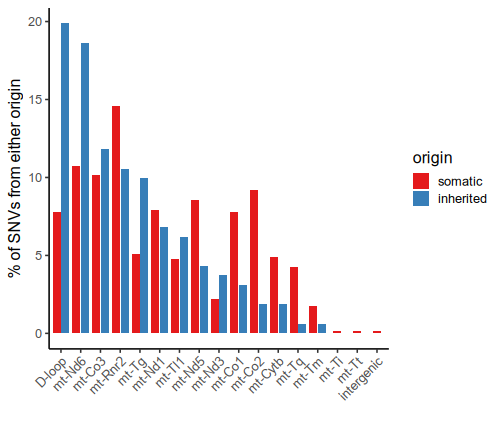

In [54]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
ggplot(comparison_noctrl_nsnvs_bygene, aes(x = gene, fill = origin, y = psnvs)) + geom_bar(stat = "identity", position = position_dodge2(preserve = "single")) + scale_x_discrete(limits = c(inherited_noctrl_nsnvs_bygene[order(-psnvs), gene], setdiff(somatic_noctrl_nsnvs_bygene[, gene], inherited_noctrl_nsnvs_bygene[, gene]))) + theme_classic(base_size = 16) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("% of SNVs from either origin") + scale_fill_brewer(palette = "Set1")

SNV rate: expected SNV sites per gene, observed SNV sites per gene for somatic and for inherited SNVs

In [55]:
somatic_noctrl_npos_bygene[, npos_expected := somatic_noctrl_npos_bygene[, sum(npos)] * nbases_covered / sum(nbases_covered)]
inherited_noctrl_npos_bygene[, npos_expected := inherited_noctrl_npos_bygene[, sum(npos)] * nbases_covered / sum(nbases_covered)]
somatic_noctrl_npos_bygene[, ratio := npos / npos_expected]
inherited_noctrl_npos_bygene[, ratio := npos / npos_expected]
somatic_noctrl_npos_bygene[, origin := "somatic"]
inherited_noctrl_npos_bygene[, origin := "inherited"]
comparison_noctrl_npos_bygene <- rbind(somatic_noctrl_npos_bygene, inherited_noctrl_npos_bygene)

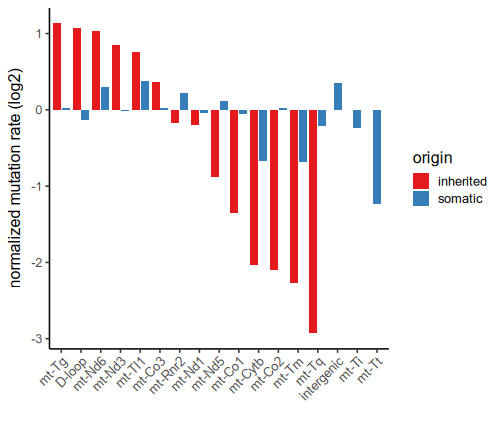

In [56]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
ggplot(comparison_noctrl_npos_bygene, aes(x = gene, y = log2(ratio), fill = origin)) + geom_bar(stat = "identity", position = position_dodge2(preserve = "single")) + scale_x_discrete(limits = c(inherited_noctrl_npos_bygene[order(-ratio), gene], setdiff(somatic_noctrl_npos_bygene[, gene], inherited_noctrl_npos_bygene[, gene])[c(3, 1, 2)])) + theme_classic(base_size = 16) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("normalized mutation rate (log2)") + scale_fill_brewer(palette = "Set1")

SNV rate by functional class (coding vs noncoding) for inherited vs somatic SNVs

In [57]:
comparison_noctrl_npos_bygene <- fread(file = "Report/SNVs/impact/comparison_noctrl_npos_bygene.csv")
comparison_noctrl_npos_byclass <- rbind(
    comparison_noctrl_npos_bygene[origin == "inherited" & gene %like% "Atp|Nd|Co|Cytb", list(origin = "inherited", class = "coding", nbases_covered = sum(nbases_covered), npos = sum(npos))], 
    comparison_noctrl_npos_bygene[origin == "inherited" & ! gene %like% "Atp|Nd|Co|Cytb", list(origin = "inherited", class = "noncoding", nbases_covered = sum(nbases_covered), npos = sum(npos))], 
    comparison_noctrl_npos_bygene[origin == "somatic" & gene %like% "Atp|Nd|Co|Cytb", list(origin = "somatic", class = "coding", nbases_covered = sum(nbases_covered), npos = sum(npos))], 
    comparison_noctrl_npos_bygene[origin == "somatic" & ! gene %like% "Atp|Nd|Co|Cytb", list(origin = "somatic", class = "noncoding", nbases_covered = sum(nbases_covered), npos = sum(npos))]
)

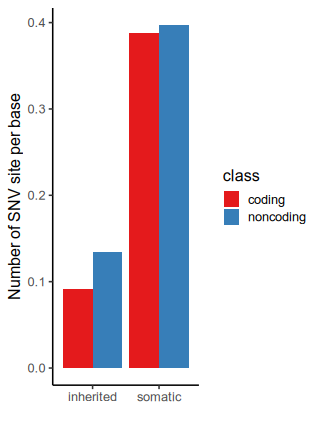

In [58]:
options(repr.plot.width = 4.5, repr.plot.height = 6, repr.plot.res = 72)
ggplot(comparison_noctrl_npos_byclass, aes(x = origin, y = npos / nbases_covered, fill = class)) + geom_bar(stat = "identity", position = "dodge") + theme_classic(16) + xlab("") + ylab("Number of SNV site per base") + scale_fill_brewer(palette = "Set1")

In [59]:
fisher.test(as.matrix(comparison_noctrl_npos_byclass[origin == "inherited", list(nbases_covered, npos)]))


	Fisher's Exact Test for Count Data

data:  as.matrix(comparison_noctrl_npos_byclass[origin == "inherited", list(nbases_covered, npos)])
p-value = 0.02842
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.033391 2.083782
sample estimates:
odds ratio 
  1.468354 


In [60]:
fisher.test(as.matrix(comparison_noctrl_npos_byclass[origin == "somatic", list(nbases_covered, npos)]))


	Fisher's Exact Test for Count Data

data:  as.matrix(comparison_noctrl_npos_byclass[origin == "somatic", list(nbases_covered, npos)])
p-value = 0.8377
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8317907 1.2553468
sample estimates:
odds ratio 
  1.022407 


ti/tv comparison for inherited vs somatic SNVs

In [61]:
inherited_noctrl_titv <- fread(file = "Report/SNVs/impact/inherited_noctrl_titv.csv")
somatic_noctrl_titv <- fread(file = "Report/SNVs/impact/somatic_noctrl_titv.csv")
inherited_noctrl_titv[, origin := "inherited"]
somatic_noctrl_titv[, origin := "somatic"]
comparison_noctrl_titv <- rbind(inherited_noctrl_titv, somatic_noctrl_titv)
comparison_noctrl_titv[class == "all", class := "average"]
comparison_noctrl_titv[class == "synonymous", class := "syn"]
comparison_noctrl_titv[class == "nonsynonymous", class := "nonsyn"]
comparison_noctrl_titv[class == "dloop", class := "D-loop"]
comparison_noctrl_titv

class,ti,tv,r,origin
<chr>,<int>,<int>,<dbl>,<chr>
average,117,39,3.0000000,inherited
nonsyn,44,14,3.1428571,inherited
syn,22,2,11.0000000,inherited
tRNA,26,2,13.0000000,inherited
rRNA,17,0,Inf,inherited
D-loop,8,21,0.3809524,inherited
average,425,196,2.1683673,somatic
nonsyn,161,104,1.5480769,somatic
syn,101,14,7.2142857,somatic


In [ ]:
fwrite(comparison_noctrl_titv, file = "Report/SNVs/impact/comparison_noctrl_titv.csv")

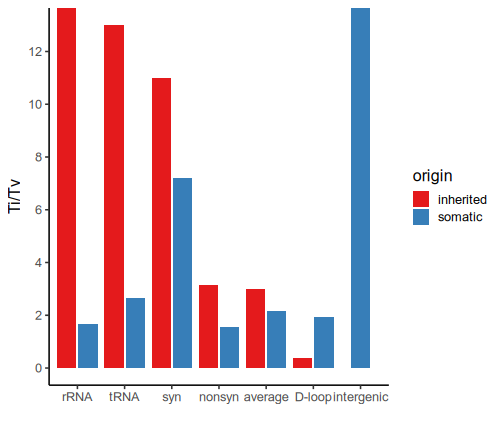

In [63]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
ggplot(comparison_noctrl_titv, aes(x = class, fill = origin, y = r)) + geom_bar(stat = "identity", position = position_dodge2(preserve = "single")) + scale_x_discrete(limits = c(comparison_noctrl_titv[origin == "inherited"][order(-r), class], "intergenic")) + theme_classic(base_size = 16)  + xlab("") + ylab("Ti/Tv") + scale_fill_brewer(palette = "Set1") + scale_y_continuous(breaks = seq(0, 12, by = 2)) ## + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

In [64]:
nherited_noctrl_titv_bygene <- fread(file = "Report/SNVs/impact/inherited_noctrl_titv_bygene.csv")
somatic_noctrl_titv_bygene <- fread(file = "Report/SNVs/impact/somatic_noctrl_titv_bygene.csv")
inherited_noctrl_titv_bygene[, origin := "inherited"]
somatic_noctrl_titv_bygene[, origin := "somatic"]
comparison_noctrl_titv_bygene <- rbind(inherited_noctrl_titv_bygene, somatic_noctrl_titv_bygene)
comparison_noctrl_titv_bygene

gene,ti,tv,r,origin
<chr>,<dbl>,<dbl>,<dbl>,<chr>
D-loop,8,21,0.3809524,inherited
mt-Co1,2,3,0.6666667,inherited
mt-Co2,3,0,Inf,inherited
mt-Co3,16,3,5.3333333,inherited
mt-Cytb,3,0,Inf,inherited
mt-Nd1,10,1,10.0000000,inherited
mt-Nd3,6,0,Inf,inherited
mt-Nd5,6,1,6.0000000,inherited
mt-Nd6,20,8,2.5000000,inherited


In [ ]:
fwrite(comparison_noctrl_titv_bygene, file = "Report/SNVs/impact/comparison_noctrl_titv_bygene.csv")

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_bar()`).”


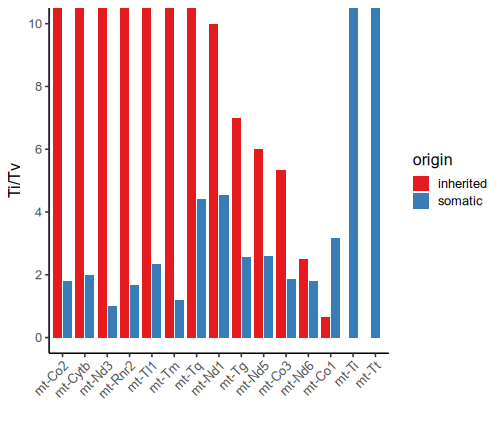

In [66]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
ggplot(comparison_noctrl_titv_bygene, aes(x = gene, fill = origin, y = r)) + geom_bar(stat = "identity", position = position_dodge2(preserve = "single")) + scale_x_discrete(limits = setdiff(unique(c(comparison_noctrl_titv_bygene[origin == "inherited"][order(-r), gene], comparison_noctrl_titv_bygene[origin == "somatic"][order(r), gene])), c("D-loop", "intergenic"))) + theme_classic(base_size = 16)  + xlab("") + ylab("Ti/Tv") + scale_fill_brewer(palette = "Set1") + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + scale_y_continuous(breaks = seq(0, 12, by = 2))


Ti/Tv by functional class (coding vs noncoding) for inherited vs somatic SNVs

In [67]:
comparison_noctrl_titv <- fread(file = "Report/SNVs/impact/comparison_noctrl_titv.csv")
comparison_noctrl_titv_byclass <- rbind(
    comparison_noctrl_titv[class != "average" & origin == "inherited" & class %in% c("nonsyn", "syn"), list(origin = "inherited", class = "coding", ti = sum(ti), tv = sum(tv), r = sum(ti)/sum(tv))], 
    comparison_noctrl_titv[class != "average" & origin == "inherited" & !class %in% c("nonsyn", "syn"), list(origin = "inherited", class = "noncoding", ti = sum(ti), tv = sum(tv), r = sum(ti)/sum(tv))], 
    comparison_noctrl_titv[class != "average" & origin == "somatic" & class %in% c("nonsyn", "syn"), list(origin = "somatic", class = "coding", ti = sum(ti), tv = sum(tv), r = sum(ti)/sum(tv))], 
    comparison_noctrl_titv[class != "average" & origin == "somatic" & !class %in% c("nonsyn", "syn"), list(origin = "somatic", class = "noncoding", ti = sum(ti), tv = sum(tv), r = sum(ti)/sum(tv))]
)
comparison_noctrl_titv_byclass

origin,class,ti,tv,r
<chr>,<chr>,<int>,<int>,<dbl>
inherited,coding,66,16,4.125000
inherited,noncoding,51,23,2.217391
somatic,coding,262,118,2.220339
somatic,noncoding,163,78,2.089744


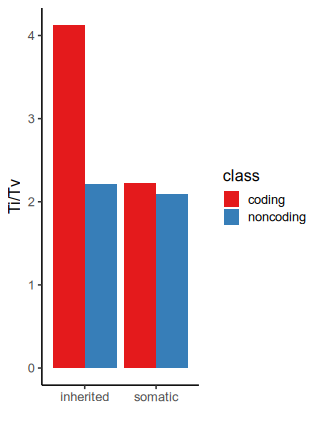

In [ ]:
options(repr.plot.width = 4.5, repr.plot.height = 6, repr.plot.res = 72)
ggplot(comparison_noctrl_titv_byclass, aes(x = origin, fill = class, y = r)) + geom_bar(stat = "identity", position = "dodge") + theme_classic(base_size = 16)  + xlab("") + ylab("Ti/Tv") + scale_fill_brewer(palette = "Set1")

In [69]:
fisher.test(as.matrix(comparison_noctrl_titv_byclass[origin == "inherited", list(ti, tv)]))


	Fisher's Exact Test for Count Data

data:  as.matrix(comparison_noctrl_titv_byclass[origin == "inherited", list(ti, tv)])
p-value = 0.1006
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8390188 4.1757872
sample estimates:
odds ratio 
  1.852849 


In [70]:
fisher.test(as.matrix(comparison_noctrl_titv_byclass[origin == "somatic", list(ti, tv)]))


	Fisher's Exact Test for Count Data

data:  as.matrix(comparison_noctrl_titv_byclass[origin == "somatic", list(ti, tv)])
p-value = 0.7905
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.7390601 1.5233002
sample estimates:
odds ratio 
  1.062389 


In [71]:
pchisq(-2 * (log(0.01) + log(1-0.79)), df = 4, lower.tail = FALSE)

[1] 0.01504822

How about the 2017 dataset?

In [72]:
Morris2017_altperc_bymito_byposmut <- fread(file = "Report/Morris2017/common_altperc_bymito_byposmut.csv")
Morris2017_common_posmut <- data.table(posmut = names(Morris2017_altperc_bymito_byposmut)[-c(1:10)])
Morris2017_common_posmut[, pos := as.integer(sapply(strsplit(posmut, ":"), "[", 1))]
Morris2017_common_posmut[, ref := sapply(strsplit(sapply(strsplit(posmut, ":"), "[", 2), ">"), "[", 1)]
Morris2017_common_posmut[, alt := sapply(strsplit(sapply(strsplit(posmut, ":"), "[", 2), ">"), "[", 2)]
fwrite(Morris2017_common_posmut, file = "Report/SNVs/impact/Morris2017_common_posmut.csv")
Morris2017_common_transmat <- dcast.data.table(Morris2017_common_posmut[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
setkey(Morris2017_common_transmat, ref)
Morris2017_common_transmat

ref,A,C,G,T
<chr>,<int>,<int>,<int>,<int>
A,NA,4,66,7
C,16,NA,1,71
G,38,1,NA,8
T,5,67,1,NA


In [ ]:
fwrite(Morris2017_common_transmat, file = "Report/SNVs/impact/Morris2017_common_transmat.csv")

In [74]:
Morris2017_common_titv <- Genetics$titv(Tools$dt2df(Morris2017_common_transmat))
Morris2017_common_titv

ti         tv          r 
242.000000  43.000000   5.627907

In [ ]:
fwrite(t(Morris2017_common_titv), file = "Report/SNVs/impact/Morris2017_common_titv.csv")

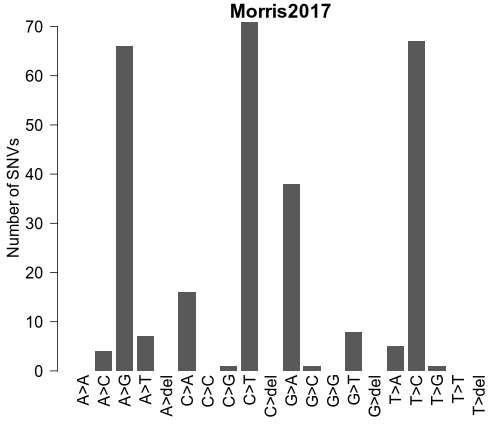

In [76]:
Morris2017_common_posmut[, mut := paste0(ref, ">", alt)]
Morris2017_common_posmut[, mut := factor(mut, levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "del")))]

options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
par(ps = 16, las = 1, lend = 2, ljoin = 1, bty = "L", mfrow = c(1, 1), mar = c(4, 4, 1.5, 0), oma = c(0, 0, 0, 0), mgp = c(2.5, 1, 0), cex.axis = 1)
invisible(x <- Morris2017_common_posmut[, barplot(table(mut), ylab = "Number of SNVs", col = "#595959", border = NA, main = "Morris2017", names.arg = FALSE)])
text(x = x, y = par()$usr[3], lab = Morris2017_common_posmut[, names(table(mut))], srt = 90, xpd = TRUE, adj = 1)

In [77]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggsignif_0.6.4    ggplot2_3.5.1     data.table_1.16.2

loaded via a namespace (and not attached):
 [1] utf8_1.2.4         generics_0.1.3     digest_0.6.37      magrittr_2